# Store Profile Classifier

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
transactions = pd.read_csv("/kaggle/input/dataset/Historical-transaction-data.csv")
storedata = pd.read_csv("/kaggle/input/dataset/Store-info.csv")
testdata = pd.read_csv("/kaggle/input/dataset/Testing-data.csv")

In [3]:
transactions.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,210,5


In [4]:
unique_shops = transactions['shop_id'].nunique()
print(unique_shops)

124


Basically there are 124 shops in total, we'll create a dataset from the transaction data

In [5]:
storedata

,shop_id,shop_area_sq_ft,shop_profile
0,SHOP047,528,Moderate
1,SHOP009,676,High
2,SHOP083,676,Low
3,SHOP117,676,Low
4,SHOP042,676,Low
...,...,...,...
119,SHOP087,527,NaN
120,SHOP050,411,NaN
121,SHOP061,699,NaN
122,SHOP056,597,NaN


# Planned Features
### Implemented
- Total Sales volume (total_vol)
- Total number of unique customers (total_customers)
- Largest volume by date? Largest volume in a single day (single_day_max_vol) ?
- Smallest volume by date? (single_day_max_vol)
- Sales volume per square foot (vol_per_sq_ft)
- Total Number of unique items (total_unique_items)
- Total transactions (n_transactions)

### Not yet implemented
- Number of recurring customers (repeating_customers)
- Number of customers who visited only once?

### Target variable is shop_profile

## Adding total_vol and vol_per_sq_ft

In [6]:
# Compute the total volume of transactions for each store_id in the dataset dataframe
total_vol_by_store = transactions.groupby('shop_id').apply(lambda x: (x['item_price'] * x['quantity_sold']).sum())

total_vol_by_store = total_vol_by_store.rename('total_vol')

# Merge the total_vol_by_store series with the storedata dataframe on the 'store_id' column
storedata = pd.merge(storedata, total_vol_by_store, on='shop_id', how='left')
storedata["vol_per_sq_ft"] = storedata["total_vol"] / storedata["shop_area_sq_ft"]
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft
0,SHOP047,528,Moderate,842960,1596.515152
1,SHOP009,676,High,1970870,2915.488166
2,SHOP083,676,Low,1691985,2502.936391
3,SHOP117,676,Low,2325980,3440.798817
4,SHOP042,676,Low,1340215,1982.566568
...,...,...,...,...,...
119,SHOP087,527,NaN,1128935,2142.191651
120,SHOP050,411,NaN,2399125,5837.287105
121,SHOP061,699,NaN,2110800,3019.742489
122,SHOP056,597,NaN,3023805,5065.000000


## Adding total_customers

In [7]:
# group the transactions dataframe by shop_id and count the number of unique customer_ids
unique_customers = transactions.groupby('shop_id')['customer_id'].nunique()

# add a new column to the storedata dataframe with the counts of unique customers
storedata['total_customers'] = storedata['shop_id'].map(unique_customers)

In [8]:
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers
0,SHOP047,528,Moderate,842960,1596.515152,928
1,SHOP009,676,High,1970870,2915.488166,2498
2,SHOP083,676,Low,1691985,2502.936391,1900
3,SHOP117,676,Low,2325980,3440.798817,2037
4,SHOP042,676,Low,1340215,1982.566568,1841
...,...,...,...,...,...,...
119,SHOP087,527,NaN,1128935,2142.191651,1083
120,SHOP050,411,NaN,2399125,5837.287105,1778
121,SHOP061,699,NaN,2110800,3019.742489,1746
122,SHOP056,597,NaN,3023805,5065.000000,2832


## Adding total_unique_items

In [9]:
# group the transactions dataframe by shop_id and count the number of unique item_descriptions
unique_items = transactions.groupby('shop_id')['item_description'].nunique()

# add a new column to the storedata dataframe with the counts of unique items
storedata['total_unique_items'] = storedata['shop_id'].map(unique_items)

## Adding single_day_max_vol

In [10]:
# assuming the transactions dataframe is already defined
# transactions['single_day_max_vol'] = transactions['item_price'] * transactions['quantity_sold']
# total_volume_per_day = transactions.groupby(['shop_id', 'transaction_date'])['single_day_max_vol'].sum().reset_index()
# highest_volume_per_shop = total_volume_per_day.groupby('shop_id')['single_day_max_vol'].max().reset_index()

# storedata = pd.merge(storedata, highest_volume_per_shop, on='shop_id')

## Adding single_day_min_vol

In [11]:
# assuming the transactions dataframe is already defined
transactions['single_day_min_vol'] = transactions['item_price'] * transactions['quantity_sold']
total_volume_per_day = transactions.groupby(['shop_id', 'transaction_date'])['single_day_min_vol'].sum().reset_index()
highest_volume_per_shop = total_volume_per_day.groupby('shop_id')['single_day_min_vol'].min().reset_index()

storedata = pd.merge(storedata, highest_volume_per_shop, on='shop_id')

In [12]:
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol
0,SHOP047,528,Moderate,842960,1596.515152,928,35,2020
1,SHOP009,676,High,1970870,2915.488166,2498,35,9230
2,SHOP083,676,Low,1691985,2502.936391,1900,36,8225
3,SHOP117,676,Low,2325980,3440.798817,2037,35,6390
4,SHOP042,676,Low,1340215,1982.566568,1841,35,5265
...,...,...,...,...,...,...,...,...
119,SHOP087,527,NaN,1128935,2142.191651,1083,35,2160
120,SHOP050,411,NaN,2399125,5837.287105,1778,31,8015
121,SHOP061,699,NaN,2110800,3019.742489,1746,35,6495
122,SHOP056,597,NaN,3023805,5065.000000,2832,35,16780


## Adding n_transactions

In [13]:
# group transactions by shop_id and count the number of unique invoice_ids
transaction_counts = transactions.groupby('shop_id')['invoice_id'].nunique()

# add a new column to storedata with the transaction counts for each shop
storedata['transaction_count'] = storedata['shop_id'].map(transaction_counts)

In [14]:
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,transaction_count
0,SHOP047,528,Moderate,842960,1596.515152,928,35,2020,1302
1,SHOP009,676,High,1970870,2915.488166,2498,35,9230,3493
2,SHOP083,676,Low,1691985,2502.936391,1900,36,8225,2718
3,SHOP117,676,Low,2325980,3440.798817,2037,35,6390,3158
4,SHOP042,676,Low,1340215,1982.566568,1841,35,5265,2495
...,...,...,...,...,...,...,...,...,...
119,SHOP087,527,NaN,1128935,2142.191651,1083,35,2160,1504
120,SHOP050,411,NaN,2399125,5837.287105,1778,31,8015,3159
121,SHOP061,699,NaN,2110800,3019.742489,1746,35,6495,2345
122,SHOP056,597,NaN,3023805,5065.000000,2832,35,16780,4320


## Adding repeating_customers

In [15]:
# Get a dataframe with the number of unique customers who visited each shop
unique_visits = transactions.groupby(['shop_id'])['customer_id'].nunique()

# Get a dataframe with the number of customers who visited each shop more than once
repeat_customers = transactions.groupby(['shop_id', 'customer_id']).size().reset_index(name='counts')
repeat_customers = repeat_customers[repeat_customers['counts'] > 1].groupby('shop_id')['customer_id'].nunique()

# Merge the two dataframes on shop_id and add a new column to storedata
storedata = storedata.merge(unique_visits, on='shop_id')
storedata = storedata.merge(repeat_customers, on='shop_id', suffixes=('_unique', '_repeating'))

In [16]:
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,transaction_count,customer_id_unique,customer_id_repeating
0,SHOP047,528,Moderate,842960,1596.515152,928,35,2020,1302,928,319
1,SHOP009,676,High,1970870,2915.488166,2498,35,9230,3493,2498,902
2,SHOP083,676,Low,1691985,2502.936391,1900,36,8225,2718,1900,700
3,SHOP117,676,Low,2325980,3440.798817,2037,35,6390,3158,2037,841
4,SHOP042,676,Low,1340215,1982.566568,1841,35,5265,2495,1841,594
...,...,...,...,...,...,...,...,...,...,...,...
119,SHOP087,527,NaN,1128935,2142.191651,1083,35,2160,1504,1083,405
120,SHOP050,411,NaN,2399125,5837.287105,1778,31,8015,3159,1778,822
121,SHOP061,699,NaN,2110800,3019.742489,1746,35,6495,2345,1746,641
122,SHOP056,597,NaN,3023805,5065.000000,2832,35,16780,4320,2832,1125


## Checking Correlation

<AxesSubplot:>

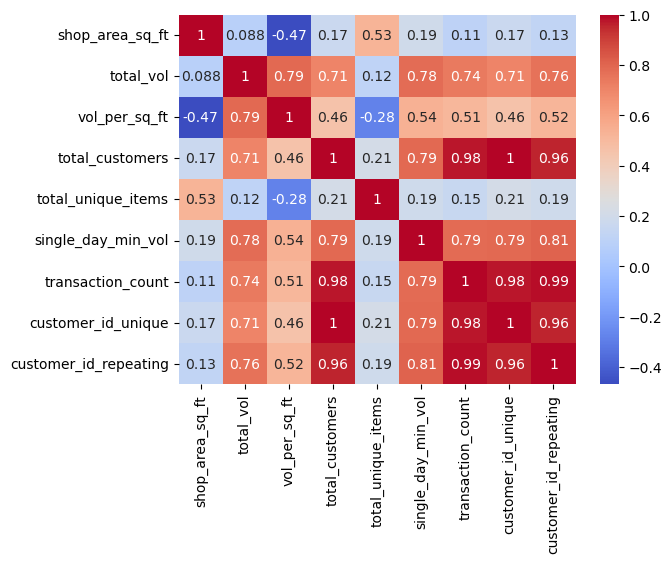

In [17]:
# create a correlation matrix
corr_matrix = storedata.corr()

# create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)

## Train test split (basically removing the testing data specified)

In [18]:
# Create a boolean mask for filtering shopdata
mask = storedata['shop_id'].isin(testdata['shop_id'])

# Create two separate dataframes
test_shops = storedata[mask]
train_shops = storedata[~mask]

In [19]:
test_shops = test_shops.drop('shop_profile', axis=1)
test_shops

,shop_id,shop_area_sq_ft,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,transaction_count,customer_id_unique,customer_id_repeating
100,SHOP046,545,2607865,4785.073394,1736,35,9805,2735,1736,683
101,SHOP024,676,1308795,1936.087278,1641,35,6210,2302,1641,578
102,SHOP023,617,2570425,4166.004862,2227,36,11240,3138,2227,792
103,SHOP097,310,2642380,8523.806452,1669,31,9530,2436,1669,631
104,SHOP044,715,1310440,1832.783217,1552,35,5465,2082,1552,511
105,SHOP030,530,2862995,5401.877358,1637,35,5845,2779,1637,719
106,SHOP038,411,1444025,3513.442822,1781,31,5045,2597,1781,634
107,SHOP029,597,1973805,3306.206030,2052,35,8220,2875,2052,751
108,SHOP096,676,2600915,3847.507396,2497,35,8605,3739,2497,978
109,SHOP092,617,1961240,3178.670989,2247,35,11600,2946,2247,745


In [20]:
train_shops

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,transaction_count,customer_id_unique,customer_id_repeating
0,SHOP047,528,Moderate,842960,1596.515152,928,35,2020,1302,928,319
1,SHOP009,676,High,1970870,2915.488166,2498,35,9230,3493,2498,902
2,SHOP083,676,Low,1691985,2502.936391,1900,36,8225,2718,1900,700
3,SHOP117,676,Low,2325980,3440.798817,2037,35,6390,3158,2037,841
4,SHOP042,676,Low,1340215,1982.566568,1841,35,5265,2495,1841,594
...,...,...,...,...,...,...,...,...,...,...,...
95,SHOP124,606,High,2967190,4896.353135,2281,35,14510,3247,2281,877
96,SHOP012,336,Low,1169405,3480.372024,1263,32,2900,1869,1263,408
97,SHOP093,705,High,1726515,2448.957447,1493,35,4145,1842,1493,473
98,SHOP004,516,Low,1571700,3045.930233,1744,35,6285,2641,1744,689


## Encoding the target variable 

### Ordinal encoding
0 = Low
1 = Moderate
2 = High

In [21]:
from sklearn.preprocessing import LabelEncoder
pd.options.mode.chained_assignment = None  # default='warn'

# Define the mapping of labels to integer codes
label_mapping = {
    'Low': 0,
    'Moderate': 1,
    'High': 2
}

# Create an instance of the LabelEncoder
encoder = LabelEncoder()

# Fit the encoder to the shop_profile column in train_shops
train_shops['shop_profile'] = encoder.fit_transform(train_shops['shop_profile'].map(label_mapping))


In [22]:
train_shops

,shop_id,shop_area_sq_ft,shop_profile,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,transaction_count,customer_id_unique,customer_id_repeating
0,SHOP047,528,1,842960,1596.515152,928,35,2020,1302,928,319
1,SHOP009,676,2,1970870,2915.488166,2498,35,9230,3493,2498,902
2,SHOP083,676,0,1691985,2502.936391,1900,36,8225,2718,1900,700
3,SHOP117,676,0,2325980,3440.798817,2037,35,6390,3158,2037,841
4,SHOP042,676,0,1340215,1982.566568,1841,35,5265,2495,1841,594
...,...,...,...,...,...,...,...,...,...,...,...
95,SHOP124,606,2,2967190,4896.353135,2281,35,14510,3247,2281,877
96,SHOP012,336,0,1169405,3480.372024,1263,32,2900,1869,1263,408
97,SHOP093,705,2,1726515,2448.957447,1493,35,4145,1842,1493,473
98,SHOP004,516,0,1571700,3045.930233,1744,35,6285,2641,1744,689


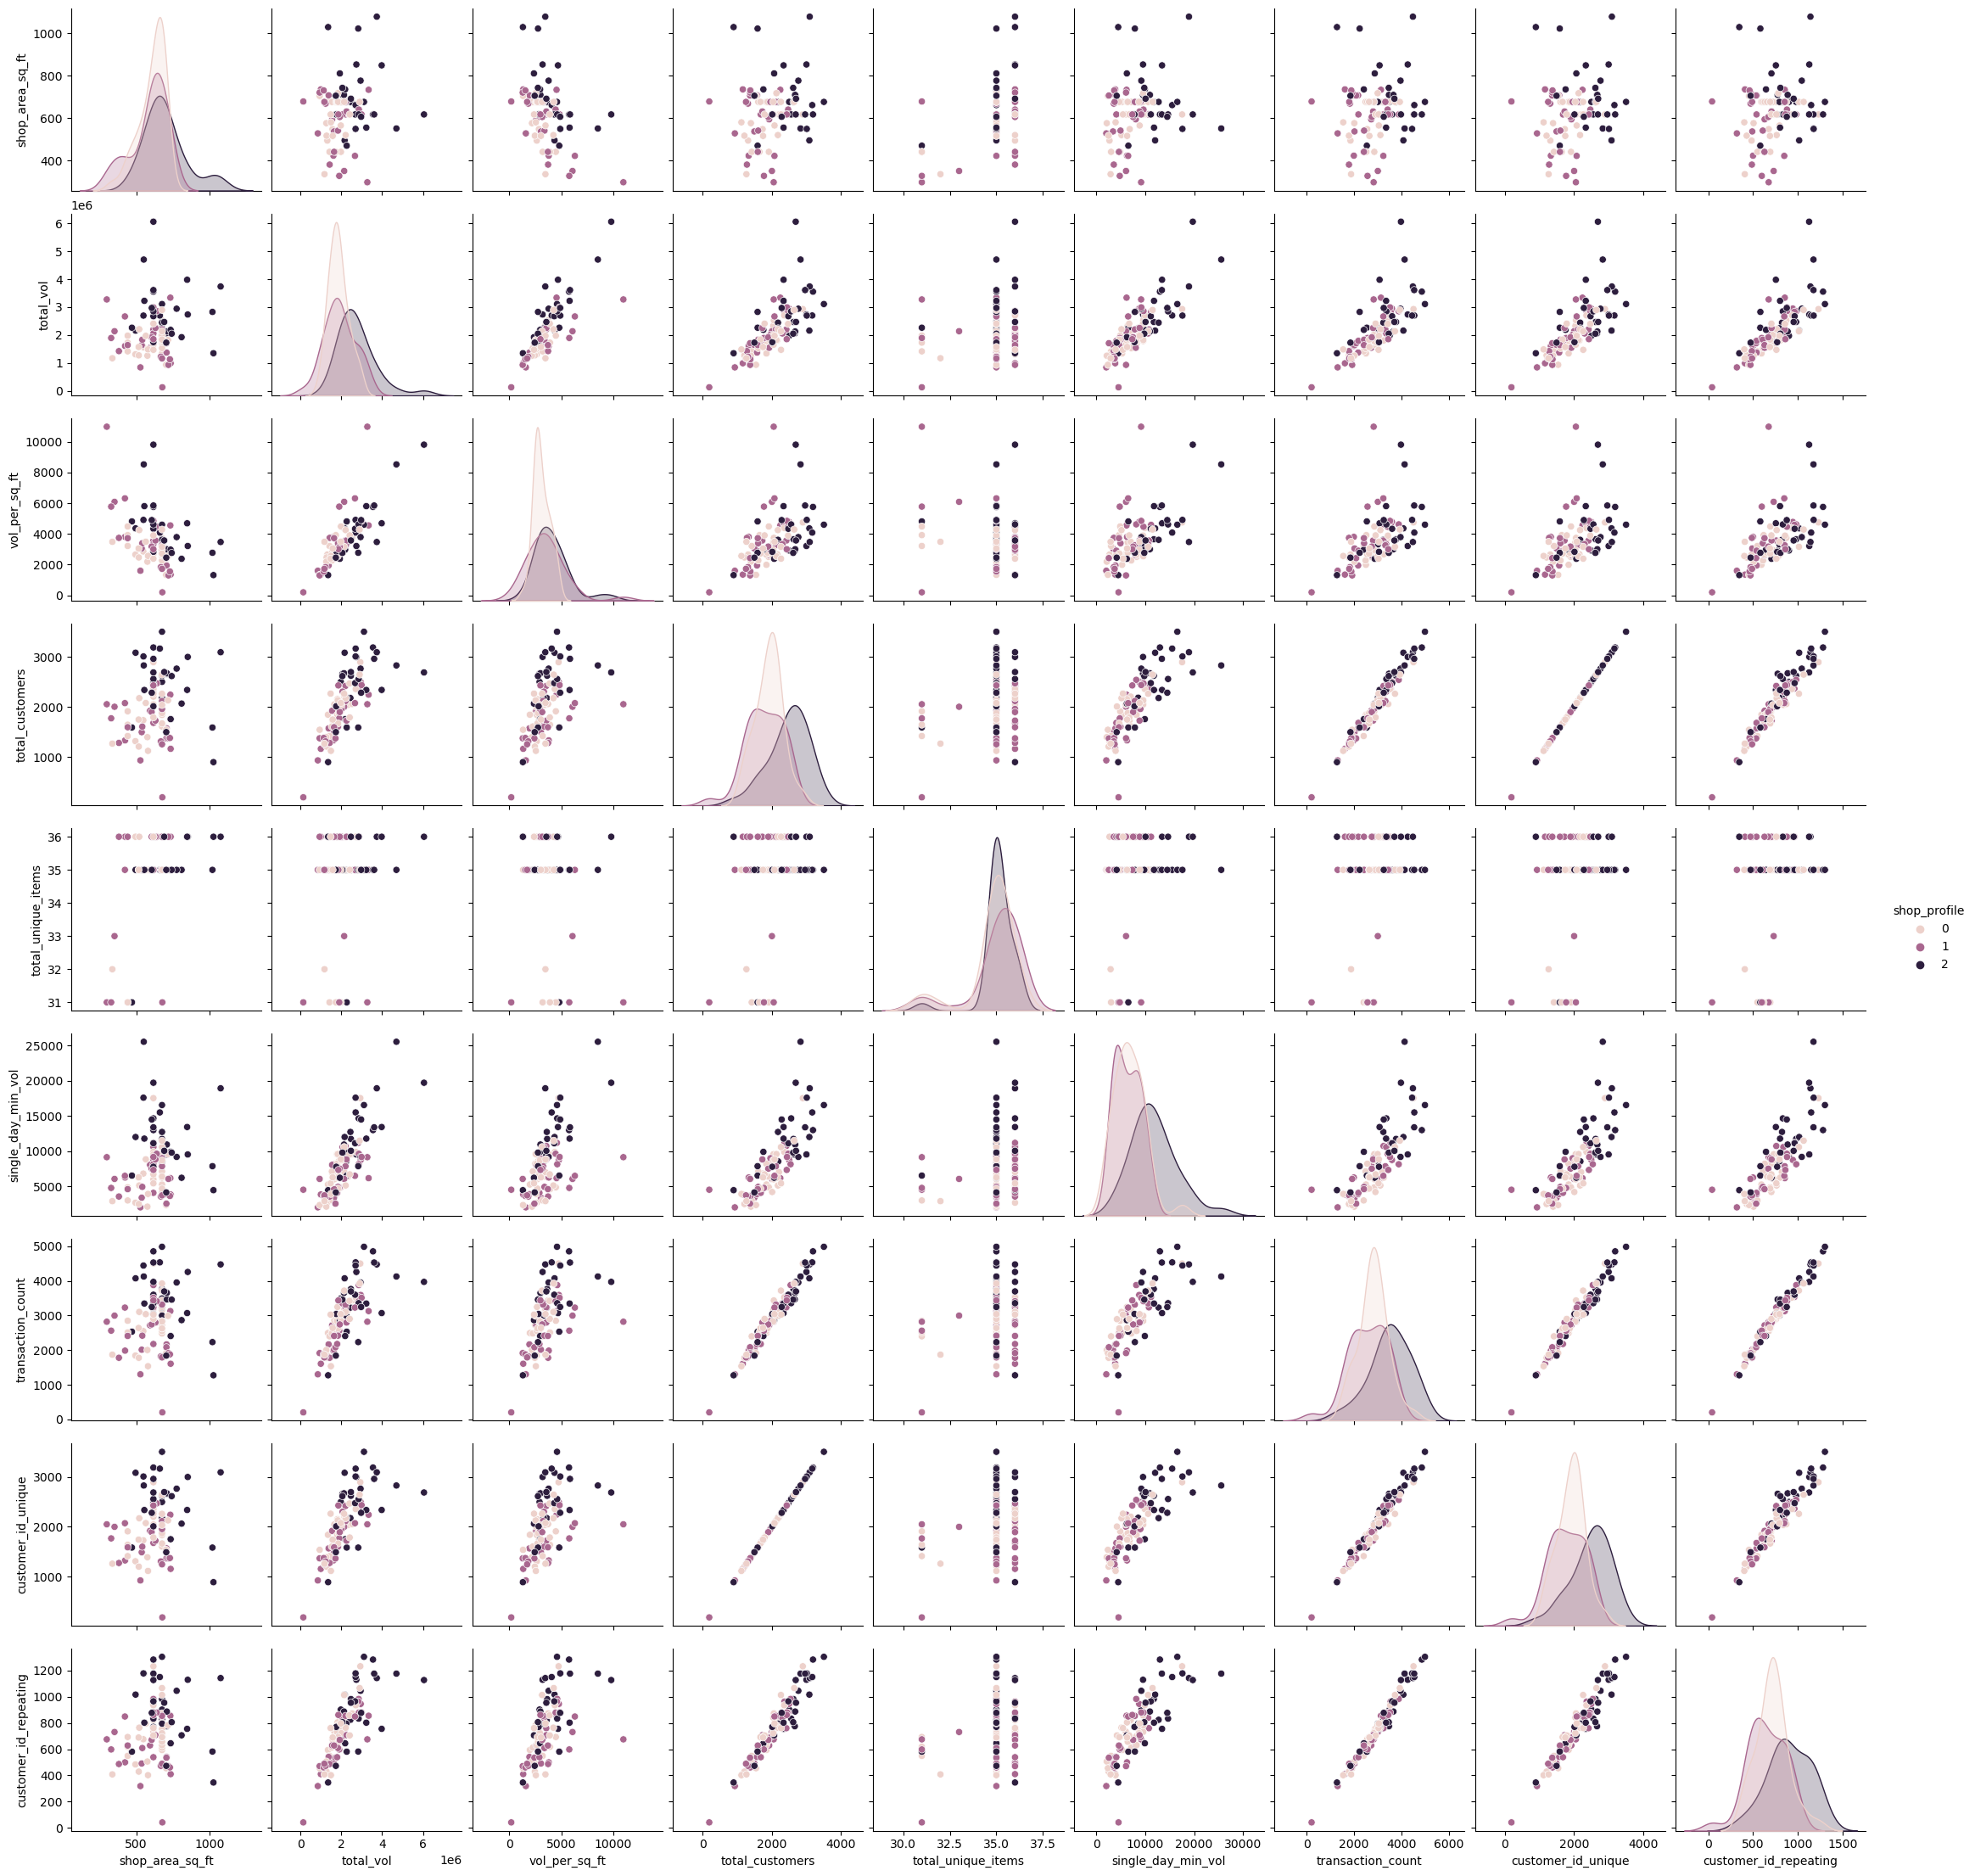

In [23]:
sns.pairplot(train_shops, hue='shop_profile')

## Selected Features


## Spliting for crossvalidation

In [24]:
y = train_shops['shop_profile']
X = train_shops.drop('shop_profile', axis=1)
X = X.drop('shop_id',axis = 1)

In [25]:
y

0     1
1     2
2     0
3     0
4     0
     ..
95    2
96    0
97    2
98    0
99    2
Name: shop_profile, Length: 100, dtype: int64

In [26]:
X

,shop_area_sq_ft,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,transaction_count,customer_id_unique,customer_id_repeating
0,528,842960,1596.515152,928,35,2020,1302,928,319
1,676,1970870,2915.488166,2498,35,9230,3493,2498,902
2,676,1691985,2502.936391,1900,36,8225,2718,1900,700
3,676,2325980,3440.798817,2037,35,6390,3158,2037,841
4,676,1340215,1982.566568,1841,35,5265,2495,1841,594
...,...,...,...,...,...,...,...,...,...
95,606,2967190,4896.353135,2281,35,14510,3247,2281,877
96,336,1169405,3480.372024,1263,32,2900,1869,1263,408
97,705,1726515,2448.957447,1493,35,4145,1842,1493,473
98,516,1571700,3045.930233,1744,35,6285,2641,1744,689


### Train test split

In [27]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

## Training the model

In [28]:
train_X

,shop_area_sq_ft,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,transaction_count,customer_id_unique,customer_id_repeating
48,720,931695,1294.020833,1370,36,6060,1915,1370,471
6,617,2946220,4775.072934,2496,35,8755,3594,2496,945
99,691,2465930,3568.639653,2695,36,10055,3697,2695,954
82,605,1917850,3170.000000,1894,36,7515,2743,1894,671
76,617,3606120,5844.602917,2959,35,13400,4531,2959,1176
...,...,...,...,...,...,...,...,...,...
96,336,1169405,3480.372024,1263,32,2900,1869,1263,408
67,520,2206435,4243.144231,2172,36,5130,3105,2172,764
64,617,2671250,4329.416532,2474,35,11135,3601,2474,965
47,617,1791290,2903.225284,1678,36,4080,2178,1678,539


In [29]:
train_y

48    1
6     1
99    2
82    1
76    2
     ..
96    0
67    0
64    2
47    1
44    1
Name: shop_profile, Length: 75, dtype: int64

In [30]:
val_X

,shop_area_sq_ft,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,transaction_count,customer_id_unique,customer_id_repeating
26,594,1543645,2598.728956,1920,35,8060,2718,1920,629
86,441,1640080,3719.002268,1591,36,4610,2411,1591,628
2,676,1691985,2502.936391,1900,36,8225,2718,1900,700
55,661,2697370,4080.741301,3164,35,15515,4536,3164,1150
75,549,2694095,4907.276867,3007,35,17610,4444,3007,1178
93,555,3220950,5803.513514,2336,35,11790,3347,2336,802
16,495,2157105,4357.787879,3081,35,12020,4075,3081,1016
73,541,1832065,3386.441774,1603,35,4930,2418,1603,609
54,617,2828540,4584.343598,2362,36,11190,3537,2362,963
95,606,2967190,4896.353135,2281,35,14510,3247,2281,877


In [31]:
val_y

26    1
86    1
2     0
55    2
75    2
93    2
16    2
73    1
54    1
95    2
53    2
92    0
78    1
13    1
7     1
30    2
22    2
24    0
33    0
8     0
43    1
62    2
3     0
71    1
45    0
Name: shop_profile, dtype: int64

### Training model

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [33]:
# Define the model with default hyperparameters
model = XGBClassifier()
# model = KNeighborsClassifier(n_neighbors= 25)
# model = RandomForestClassifier(n_estimators=100,random_state=1)

# Fit the model to the training data
model.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

## Making predictions

In [34]:
# Make predictions on the test data
y_pred = model.predict(val_X)

## F1 Score

In [35]:
from sklearn.metrics import f1_score

# Calculate the F1 score
f1 = f1_score(val_y, y_pred,average='micro')

# Print the result
print("F1 score:", f1)

F1 score: 0.64


## For submissions Train using full X and y sets

In [36]:
# Define the model with default hyperparameters
FinalModel = XGBClassifier()
# FinalModel = KNeighborsClassifier(n_neighbors=3)
# FinalModel = RandomForestClassifier(n_estimators=100,random_state=1)

# Fit the model to the training data
FinalModel.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [37]:
test_shops = test_shops.drop('shop_id', axis=1)
test_shops

,shop_area_sq_ft,total_vol,vol_per_sq_ft,total_customers,total_unique_items,single_day_min_vol,transaction_count,customer_id_unique,customer_id_repeating
100,545,2607865,4785.073394,1736,35,9805,2735,1736,683
101,676,1308795,1936.087278,1641,35,6210,2302,1641,578
102,617,2570425,4166.004862,2227,36,11240,3138,2227,792
103,310,2642380,8523.806452,1669,31,9530,2436,1669,631
104,715,1310440,1832.783217,1552,35,5465,2082,1552,511
105,530,2862995,5401.877358,1637,35,5845,2779,1637,719
106,411,1444025,3513.442822,1781,31,5045,2597,1781,634
107,597,1973805,3306.206030,2052,35,8220,2875,2052,751
108,676,2600915,3847.507396,2497,35,8605,3739,2497,978
109,617,1961240,3178.670989,2247,35,11600,2946,2247,745


In [38]:
FinalPred = FinalModel.predict(test_shops)

In [39]:
len(FinalPred)

24

## Combining predictions with shop_id

In [40]:
# Create a dictionary mapping the old values to the new values
mapping = {0: 'Low', 1: 'Moderate', 2: 'High'}

# Map the values in the 'shop_profile' column using the dictionary
testdata["shop_profile"] = FinalPred

In [41]:
testdata

,shop_id,shop_profile
0,SHOP046,1
1,SHOP024,0
2,SHOP023,0
3,SHOP097,2
4,SHOP044,1
5,SHOP030,1
6,SHOP038,0
7,SHOP029,0
8,SHOP096,2
9,SHOP092,0


In [42]:
# Define a dictionary to map values to labels
label_map = {0: 'Low', 1: 'Moderate', 2: 'High'}

# Replace the values in the shop_profile column with labels
testdata['shop_profile'] = testdata['shop_profile'].replace(label_map)

In [43]:
## Write to CSV
testdata.to_csv('output.csv', index=False)
print("Done!!")

Done!!
